In [1]:
#Libraries
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
import optuna
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.preprocessing import LabelEncoder
pd.set_option("display.max_columns", 101)

Column | Description
:---|:---
`id` | Unique id of every property
`area` | Area of the structure (sq. feet)
`bathrooms` | Number of bathrooms
`bedrooms` | Number of rooms
`condo_fee`| Condominium fee `(US $$)` 
`parking_spots`| Number of parking spots
`attached_rooms` | Number of bedrooms with direct access to a bathroom.
`type` | Kind of real estate
`lat` | Latitude of the property
`lon` | Longitude of the property
`year_built` | Year the real property was built
`overall_condition` | Abstract evaluation of the owner
`has_elevator` | If the property has elevator or not
`leasures_available` | List of leasures in the property
`price`| Price of the real estate `(US $$)`

## Data Wrangling & Visualization

In [2]:
# Dataset is already loaded below
data = pd.read_csv("data/train.csv")
data.shape

(4000, 15)

In [3]:
data.columns

Index(['id', 'area', 'bathrooms', 'bedrooms', 'condo_fee', 'parking_spots',
       'attached_rooms', 'type', 'lat', 'lon', 'year_built',
       'overall_condition', 'has_elevator', 'leasures_available', 'price'],
      dtype='object')

In [4]:
data.head()

,id,area,bathrooms,bedrooms,condo_fee,parking_spots,attached_rooms,type,lat,lon,year_built,overall_condition,has_elevator,leasures_available,price
0,1,1645,4,4,142,-4,4,NaN,69.939910,84.891532,1975,Score 2,no,"barbecue space,sports court pool, SPORTS COURT",693607
1,2,2171,3,5,297,-2,0,NaN,52.634843,88.743554,1988,Score 7,no,"pool,playground,SPORTS COURT",569200
2,3,1107,2,5,136,-2,4,other,48.088470,-95.966007,1952,Score 0,yes,barbecue space,380116
3,4,2879,1,4,86,-1,2,other,-6.087764,-142.616533,1951,Score 5,no,"POOL,BARBECUE SPACE,GYM,playground BARBECUE SP...",535579
4,5,2044,1,1,227,-5,1,house,8.707313,149.938432,1966,Score 4,yes,POOL,120668


In [5]:
data.isnull().sum()

id                      0
area                    0
bathrooms               0
bedrooms                0
condo_fee               0
parking_spots           0
attached_rooms          0
type                  981
lat                     0
lon                     0
year_built              0
overall_condition       0
has_elevator            0
leasures_available    192
price                   0
dtype: int64

In [6]:
# drop id column
data.drop(columns=['id'], axis=1, inplace=True)

# Encoding categorical values

In [7]:
# data['has_elevator'].replace({'Yes':1, 'No':0, 'yes':1, 'y':1, 'nop':0, 'no':0}, inplace=True)

# Data Visualizations

### Check the relationship between the area of the property and its price. Since some areas are overpriced due to location and other accessibility factors like airports, train stations, malls etc

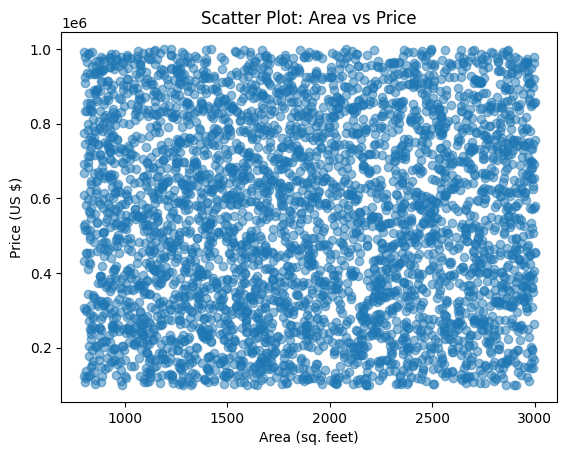

In [8]:
# Scatter plot
plt.scatter(data['area'], data['price'], alpha=0.5)
plt.xlabel('Area (sq. feet)')
plt.ylabel('Price (US $)')
plt.title('Scatter Plot: Area vs Price')
plt.show()

### distribution of prices based on the type of real estate (e.g., apartment, house, condo). This can reveal any variations in prices across different types of properties.

<Figure size 800x600 with 0 Axes>

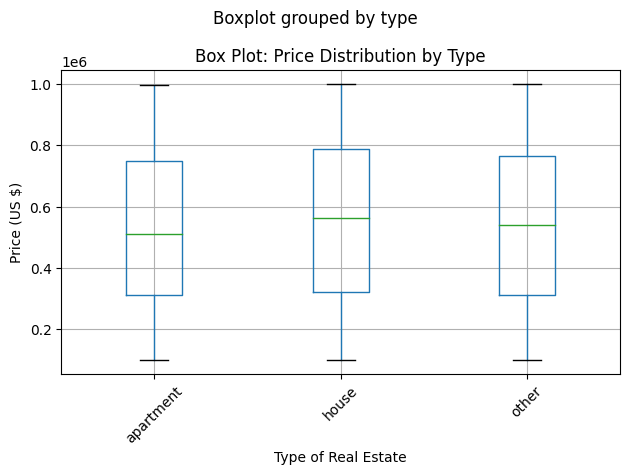

In [9]:
# Box plot
plt.figure(figsize=(8, 6))
data.boxplot(column='price', by='type')
plt.xlabel('Type of Real Estate')
plt.ylabel('Price (US $)')
plt.title('Box Plot: Price Distribution by Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Visualize the distribution of prices to understand the frequency of different price ranges within the dataset.

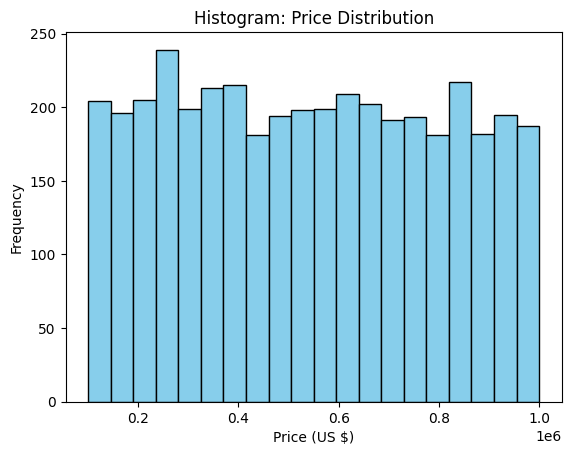

In [10]:
# Histogram
plt.hist(data['price'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Price (US $)')
plt.ylabel('Frequency')
plt.title('Histogram: Price Distribution')
plt.show()

###  distribution of houses by their overall condition categories. check if data is imbalanced if poor condition houses are more it could lead to underprediction of price 

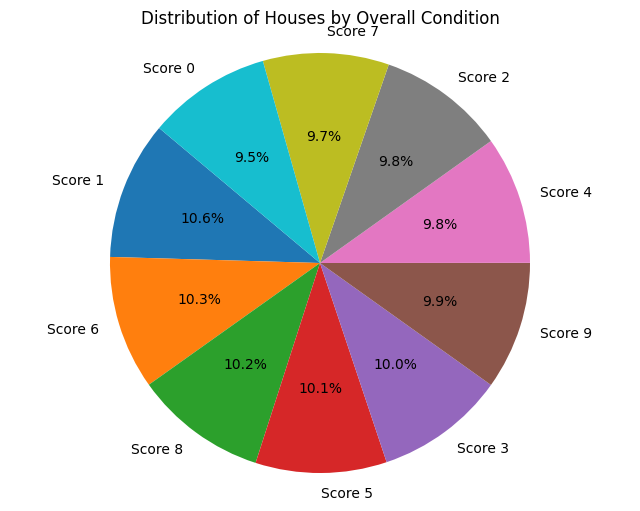

In [11]:
# Pie chart
overall_condition_counts = data['overall_condition'].value_counts()

# Pie chart
plt.figure(figsize=(8, 6))
plt.pie(overall_condition_counts.values, labels=overall_condition_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Houses by Overall Condition')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

###  correlations between different numerical features (e.g., area, bathrooms, bedrooms) and the target variable (price).

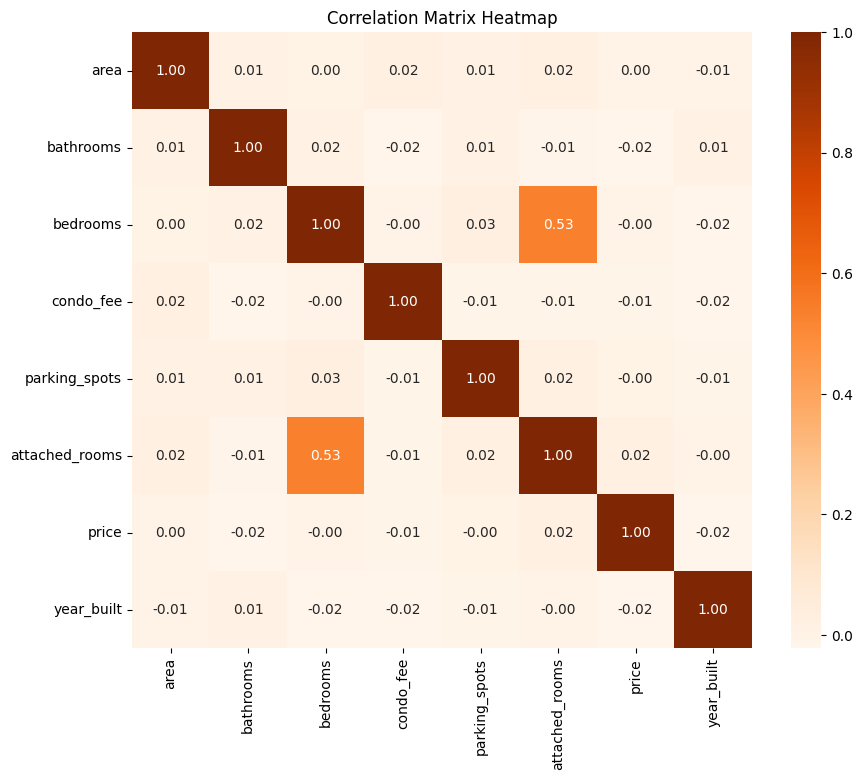

In [12]:
# check correlations for some features
selected_columns = data[['area', 'bathrooms', 'bedrooms', 'condo_fee', 'parking_spots',
       'attached_rooms', 'price',
                        'year_built',  #dont know whether to use it 
                        ]]

# Calculate correlation matrix for numerical columns
correlation_matrix = selected_columns.corr()

# Plot correlation matrix heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='Oranges', fmt=".2f")
plt.title('Correlation Matrix Heatmap')
plt.show()

### Conclusions from EDA:
1) There are outliers in all features (they should be processed)
2) In general, the distribution of target is close to normal there are some outliers present ###CHECK
3) High correlation (~0.7) between target variable(median_house_value) and median_income
4) High correlation between features, this is multicollinearity
5) Features of longitude and latitude are valuable information, use this in feature generation

### Remove outliers from target variable

In [14]:
data.shape

(4000, 14)

In [15]:
Q1 = data['price'].quantile(0.25)
Q3 = data['price'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5*IQR
upper = Q3 + 1.5*IQR
 
# Create arrays of Boolean values indicating the outlier rows
upper_array = np.where(data['price'] >= upper)[0]
lower_array = np.where(data['price'] <= lower)[0]
 
# Removing the outliers
data.drop(index=upper_array, inplace=True)
data.drop(index=lower_array, inplace=True)

data.shape

(4000, 14)

# Encoding categorical values

In [16]:
data['has_elevator'].replace({'Yes':1, 'No':0, 'yes':1, 'y':1, 'nop':0, 'no':0}, inplace=True)

In [17]:
data = pd.get_dummies(data, columns=['overall_condition'], drop_first=True)

In [18]:
data.head()

,area,bathrooms,bedrooms,condo_fee,parking_spots,attached_rooms,type,lat,lon,year_built,has_elevator,leasures_available,price,overall_condition_Score 1,overall_condition_Score 2,overall_condition_Score 3,overall_condition_Score 4,overall_condition_Score 5,overall_condition_Score 6,overall_condition_Score 7,overall_condition_Score 8,overall_condition_Score 9
0,1645,4,4,142,-4,4,NaN,69.939910,84.891532,1975,0,"barbecue space,sports court pool, SPORTS COURT",693607,0,1,0,0,0,0,0,0,0
1,2171,3,5,297,-2,0,NaN,52.634843,88.743554,1988,0,"pool,playground,SPORTS COURT",569200,0,0,0,0,0,0,1,0,0
2,1107,2,5,136,-2,4,other,48.088470,-95.966007,1952,1,barbecue space,380116,0,0,0,0,0,0,0,0,0
3,2879,1,4,86,-1,2,other,-6.087764,-142.616533,1951,0,"POOL,BARBECUE SPACE,GYM,playground BARBECUE SP...",535579,0,0,0,0,1,0,0,0,0
4,2044,1,1,227,-5,1,house,8.707313,149.938432,1966,1,POOL,120668,0,0,0,1,0,0,0,0,0


# encode leasures_available

In [19]:
data['leasures_available'].unique()

array(['barbecue space,sports court pool, SPORTS COURT',
       'pool,playground,SPORTS COURT', 'barbecue space',
       'POOL,BARBECUE SPACE,GYM,playground BARBECUE SPACE, PLAYGROUND',
       'POOL',
       'pool, BARBECUE SPACE. "barbecue space,playground, SPORTS COURT',
       'PLAYGROUND,SPORTS COURT BARBECUE SPACE,playground,SPORTS COURT',
       'barbecue space, GYM,playground, sports court BARBECUE SPACE,playground,sports court',
       nan, 'gym',
       'pool,PLAYGROUND POOL,BARBECUE SPACE,playground POOL, BARBECUE SPACE,playground,sports court',
       '"pool,barbecue space,PLAYGROUND "PLAYGROUND,sports court',
       'SPORTS COURT POOL,barbecue space,gym, PLAYGROUND, SPORTS COURT*',
       'pool BARBECUE SPACE,PLAYGROUND, sports court',
       'BARBECUE SPACE POOL, playground',
       'POOL,BARBECUE SPACE,PLAYGROUND',
       'playground barbecue space,PLAYGROUND,sports court',
       'BARBECUE SPACE,playgpound playground, SPORTS COURT',
       'PLAYGROUND POOL,barbecue space

In [20]:
leasures_list = ['barbecue space', 'sports court', 'pool', 'playground', 'gym']

In [21]:
import pandas as pd
import numpy as np


# Define the list of leisure activities
leasures_list = ['barbecue space', 'sports court', 'pool', 'playground', 'gym']

# Function to encode features based on presence in tokens
def encode_features(tokens):
    features = {
        'has_barbecue_space': int(any('barbecue space' in ' '.join(tokens).lower() for token in tokens)),
        'has_sports_court': int(any('sports court' in ' '.join(tokens).lower() for token in tokens)),
        'has_pool': int(any('pool' in token.lower() for token in tokens)),
        'has_gym': int(any('gym' in token.lower() for token in tokens)),
        'has_playground': int(any('playground' in token.lower() for token in tokens)),
        # Add more features as needed
    }
    return features

# Preprocess the 'leasures_available' column and create new columns for each activity
data['leasures_available'] = data['leasures_available'].apply(lambda x: ' '.join(set(x.lower().split(','))) if isinstance(x, str) else np.nan)
encoded_features = data['leasures_available'].apply(lambda x: encode_features(x.split()) if isinstance(x, str) else {})

# Convert the encoded features to a DataFrame
encoded_features = pd.DataFrame(encoded_features.tolist())

# Merge the encoded features with the original DataFrame
data = pd.concat([data, encoded_features], axis=1)

# print(data)



In [22]:
data.columns

Index(['area', 'bathrooms', 'bedrooms', 'condo_fee', 'parking_spots',
       'attached_rooms', 'type', 'lat', 'lon', 'year_built', 'has_elevator',
       'leasures_available', 'price', 'overall_condition_Score 1',
       'overall_condition_Score 2', 'overall_condition_Score 3',
       'overall_condition_Score 4', 'overall_condition_Score 5',
       'overall_condition_Score 6', 'overall_condition_Score 7',
       'overall_condition_Score 8', 'overall_condition_Score 9',
       'has_barbecue_space', 'has_sports_court', 'has_pool', 'has_gym',
       'has_playground'],
      dtype='object')

In [23]:
data.head()

,area,bathrooms,bedrooms,condo_fee,parking_spots,attached_rooms,type,lat,lon,year_built,has_elevator,leasures_available,price,overall_condition_Score 1,overall_condition_Score 2,overall_condition_Score 3,overall_condition_Score 4,overall_condition_Score 5,overall_condition_Score 6,overall_condition_Score 7,overall_condition_Score 8,overall_condition_Score 9,has_barbecue_space,has_sports_court,has_pool,has_gym,has_playground
0,1645,4,4,142,-4,4,NaN,69.939910,84.891532,1975,0,barbecue space sports court pool sports court,693607,0,1,0,0,0,0,0,0,0,1.0,1.0,1.0,0.0,0.0
1,2171,3,5,297,-2,0,NaN,52.634843,88.743554,1988,0,pool playground sports court,569200,0,0,0,0,0,0,1,0,0,0.0,1.0,1.0,0.0,1.0
2,1107,2,5,136,-2,4,other,48.088470,-95.966007,1952,1,barbecue space,380116,0,0,0,0,0,0,0,0,0,1.0,0.0,0.0,0.0,0.0
3,2879,1,4,86,-1,2,other,-6.087764,-142.616533,1951,0,barbecue space playground barbecue space pool ...,535579,0,0,0,0,1,0,0,0,0,1.0,0.0,1.0,1.0,1.0
4,2044,1,1,227,-5,1,house,8.707313,149.938432,1966,1,pool,120668,0,0,0,1,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0


In [24]:
data.drop(columns=['leasures_available'], axis=1, inplace=True)

### encoding real estate type

In [25]:
data['type'].unique()

array([nan, 'other', 'house', 'apartment'], dtype=object)

In [26]:
data = pd.get_dummies(data, columns=['type'])
data.drop('type_other', axis=1, inplace=True)

In [27]:
data.head()

,area,bathrooms,bedrooms,condo_fee,parking_spots,attached_rooms,lat,lon,year_built,has_elevator,price,overall_condition_Score 1,overall_condition_Score 2,overall_condition_Score 3,overall_condition_Score 4,overall_condition_Score 5,overall_condition_Score 6,overall_condition_Score 7,overall_condition_Score 8,overall_condition_Score 9,has_barbecue_space,has_sports_court,has_pool,has_gym,has_playground,type_apartment,type_house
0,1645,4,4,142,-4,4,69.939910,84.891532,1975,0,693607,0,1,0,0,0,0,0,0,0,1.0,1.0,1.0,0.0,0.0,0,0
1,2171,3,5,297,-2,0,52.634843,88.743554,1988,0,569200,0,0,0,0,0,0,1,0,0,0.0,1.0,1.0,0.0,1.0,0,0
2,1107,2,5,136,-2,4,48.088470,-95.966007,1952,1,380116,0,0,0,0,0,0,0,0,0,1.0,0.0,0.0,0.0,0.0,0,0
3,2879,1,4,86,-1,2,-6.087764,-142.616533,1951,0,535579,0,0,0,0,1,0,0,0,0,1.0,0.0,1.0,1.0,1.0,0,0
4,2044,1,1,227,-5,1,8.707313,149.938432,1966,1,120668,0,0,0,1,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,0,1


### make bins for year built

In [28]:
data['year_built'].unique()

array([1975, 1988, 1952, 1951, 1966, 1992, 1996, 1976, 2016, 1977, 2015,
       2009, 1964, 2000, 2006, 1993, 2005, 2013, 1967, 1972, 1984, 2007,
       1995, 1999, 1968, 1954, 2014, 1970, 1953, 1969, 1965, 1959, 1955,
       1958, 1960, 2011, 1986, 1962, 2002, 2020, 1990, 2019, 1961, 1973,
       1978, 2012, 2004, 1998, 2017, 2008, 1983, 1997, 1979, 1994, 1963,
       2010, 1991, 1982, 2018, 1989, 1980, 1985, 2001, 1974, 1987, 1971,
       1950, 2003, 1981, 1956, 1957], dtype=int64)

In [29]:
# Determine min and max year
min_year = data['year_built'].min()
max_year = data['year_built'].max()

# Create decade bins
decade_bins = [decade for decade in range(min_year - min_year % 10, max_year + 11, 10)]

# Create bins based on decade bins
data['decade_built'] = pd.cut(data['year_built'], bins=decade_bins, labels=[f'{decade}s' for decade in decade_bins[:-1]])
data.drop('year_built', axis=1, inplace=True)

In [30]:
data.head()

,area,bathrooms,bedrooms,condo_fee,parking_spots,attached_rooms,lat,lon,has_elevator,price,overall_condition_Score 1,overall_condition_Score 2,overall_condition_Score 3,overall_condition_Score 4,overall_condition_Score 5,overall_condition_Score 6,overall_condition_Score 7,overall_condition_Score 8,overall_condition_Score 9,has_barbecue_space,has_sports_court,has_pool,has_gym,has_playground,type_apartment,type_house,decade_built
0,1645,4,4,142,-4,4,69.939910,84.891532,0,693607,0,1,0,0,0,0,0,0,0,1.0,1.0,1.0,0.0,0.0,0,0,1970s
1,2171,3,5,297,-2,0,52.634843,88.743554,0,569200,0,0,0,0,0,0,1,0,0,0.0,1.0,1.0,0.0,1.0,0,0,1980s
2,1107,2,5,136,-2,4,48.088470,-95.966007,1,380116,0,0,0,0,0,0,0,0,0,1.0,0.0,0.0,0.0,0.0,0,0,1950s
3,2879,1,4,86,-1,2,-6.087764,-142.616533,0,535579,0,0,0,0,1,0,0,0,0,1.0,0.0,1.0,1.0,1.0,0,0,1950s
4,2044,1,1,227,-5,1,8.707313,149.938432,1,120668,0,0,0,1,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,0,1,1960s


In [31]:
label_encoder = LabelEncoder()

# Fit and transform the 'decade_built' column using LabelEncoder
data['decade_built'] = label_encoder.fit_transform(data['decade_built'])

In [32]:
data.head()

,area,bathrooms,bedrooms,condo_fee,parking_spots,attached_rooms,lat,lon,has_elevator,price,overall_condition_Score 1,overall_condition_Score 2,overall_condition_Score 3,overall_condition_Score 4,overall_condition_Score 5,overall_condition_Score 6,overall_condition_Score 7,overall_condition_Score 8,overall_condition_Score 9,has_barbecue_space,has_sports_court,has_pool,has_gym,has_playground,type_apartment,type_house,decade_built
0,1645,4,4,142,-4,4,69.939910,84.891532,0,693607,0,1,0,0,0,0,0,0,0,1.0,1.0,1.0,0.0,0.0,0,0,2
1,2171,3,5,297,-2,0,52.634843,88.743554,0,569200,0,0,0,0,0,0,1,0,0,0.0,1.0,1.0,0.0,1.0,0,0,3
2,1107,2,5,136,-2,4,48.088470,-95.966007,1,380116,0,0,0,0,0,0,0,0,0,1.0,0.0,0.0,0.0,0.0,0,0,0
3,2879,1,4,86,-1,2,-6.087764,-142.616533,0,535579,0,0,0,0,1,0,0,0,0,1.0,0.0,1.0,1.0,1.0,0,0,0
4,2044,1,1,227,-5,1,8.707313,149.938432,1,120668,0,0,0,1,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,0,1,1


# Feature selection through XGBoost feature importance scores

In [33]:
X = data.drop("price", axis=1)
y = data["price"]

# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
# X_train.shape, X_val.shape

optimize hyperparameters, we take the XGBRegressor model

There are many advantages of XGBoost, some of them are mentioned below:
1) It is Highly Flexible
2) It uses the power of parallel processing
3) It is faster than Gradient Boosting
4) It supports regularization
5) It is designed to handle missing data with its in-build features
6) The user can run a cross-validation after each iteration
7) It Works well in small to medium dataset

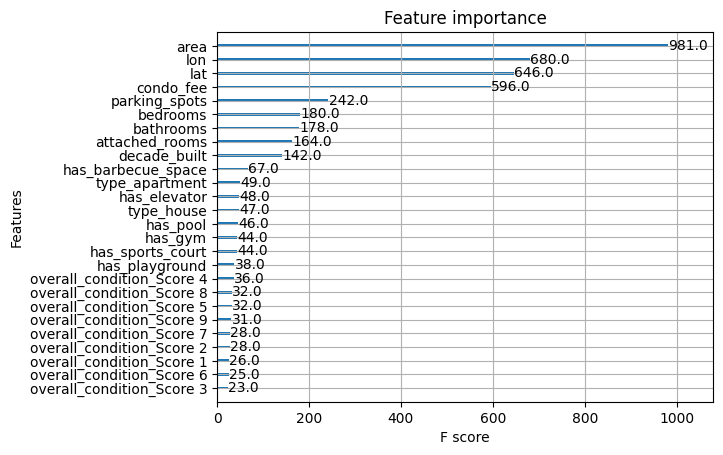

In [34]:
model = XGBRegressor()
model.fit(X, y)
# plot feature importance
plot_importance(model)
plt.show()

## Hyperparameter tuning by using selected features

In [35]:
# df = data[[ ]]
# X = df.drop("price", axis=1)
# y = df["price"]

In [36]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_val.shape

((3200, 26), (800, 26))

In [41]:
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 400, 1000, step=100),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),  
        "max_depth": trial.suggest_int("max_depth", 2, 8),
        "subsample": trial.suggest_float("subsample", 0.7, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0, step=0.1),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),  ###CHECK AND REFER EXAMPLES
    }

    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train, verbose=False)
    predictions = model.predict(X_val)
    print(predictions)
    
#     plot_importance(model)
#     plt.show()
    
    # Calculate MAPE
    mape = mean_absolute_percentage_error(y_val, predictions)
    return mape


In [42]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=3)

[I 2024-04-20 17:42:52,661] A new study created in memory with name: no-name-99ff0dd1-ed0f-4e1b-93b4-2ebefb7419be
[I 2024-04-20 17:42:57,148] Trial 0 finished with value: 0.6819043356921927 and parameters: {'n_estimators': 1000, 'learning_rate': 0.008791357104019373, 'max_depth': 4, 'subsample': 0.9470608449374505, 'colsample_bytree': 1.0, 'min_child_weight': 11}. Best is trial 0 with value: 0.6819043356921927.


[561461.25 537227.9  541988.4  562299.   555124.8  509243.4  578271.94
 568291.06 554838.4  588257.25 511004.06 604422.8  560551.2  480783.78
 522487.78 552502.2  489814.03 507273.22 410715.8  547425.1  523676.56
 534054.1  493446.72 578043.56 468193.78 581899.2  539451.1  531763.44
 462707.72 464571.34 566104.75 464042.25 503299.62 575757.9  454144.9
 536126.7  543734.2  520061.4  550132.   578066.6  503228.1  529223.06
 497951.53 505210.66 562540.94 552400.06 537637.25 548808.94 531043.1
 466249.28 556240.44 586888.3  575048.1  540388.5  560618.8  513620.47
 516603.22 488480.28 504481.28 570707.8  562537.5  538992.3  618553.2
 586766.8  527133.75 518003.47 591333.   541961.25 495084.22 622147.44
 520190.38 518731.28 527278.4  496088.78 574397.5  581017.2  456448.
 581952.3  567017.7  472884.06 550166.06 504260.47 601233.5  510806.53
 508881.06 573216.9  532523.44 464651.4  526773.1  564563.5  515253.28
 466930.78 471696.88 619338.56 578580.44 523717.6  558998.3  440739.44
 564598.5  

[I 2024-04-20 17:43:01,689] Trial 1 finished with value: 0.6456334248651595 and parameters: {'n_estimators': 700, 'learning_rate': 0.004125569483899191, 'max_depth': 4, 'subsample': 0.7033862504967467, 'colsample_bytree': 0.9, 'min_child_weight': 9}. Best is trial 1 with value: 0.6456334248651595.


[507733.47 501497.16 492499.22 530540.9  524286.06 498648.44 525322.4
 522852.3  521171.6  532243.44 503723.78 538845.7  482823.97 483921.5
 499298.88 503429.9  472531.97 486503.88 445226.97 503113.22 497043.56
 511738.38 466243.84 549338.75 483831.8  532882.7  512446.12 515853.16
 468868.53 462396.47 513764.8  490750.4  486276.4  515533.72 479029.9
 505890.47 514478.12 516840.38 510364.1  526662.4  486498.4  502261.97
 500466.8  490322.25 517206.94 515813.66 516464.84 513730.7  526714.25
 475711.4  519927.88 529836.2  507129.97 500726.84 504396.12 489287.06
 495189.34 489961.66 489288.75 537492.6  518499.94 523917.97 526456.75
 530439.9  512962.47 511012.8  489743.9  509473.44 492820.88 566405.56
 498978.84 501185.8  501009.3  480350.53 538685.56 534970.3  458566.53
 527958.5  520026.97 470693.22 520338.6  493218.47 521609.75 503102.72
 481274.7  518390.9  516661.62 471229.16 494057.53 534638.06 497981.78
 471173.75 465296.84 560229.75 538480.75 498614.97 529732.   464843.12
 517744.3

[I 2024-04-20 17:43:05,387] Trial 2 finished with value: 0.6320282045574589 and parameters: {'n_estimators': 500, 'learning_rate': 0.004973701969301854, 'max_depth': 5, 'subsample': 0.8810307484434523, 'colsample_bytree': 1.0, 'min_child_weight': 20}. Best is trial 2 with value: 0.6320282045574589.


[501432.6  496732.78 480799.53 512288.1  503246.34 479029.06 508373.8
 503726.88 510743.38 524904.94 481983.2  520674.75 462933.7  462614.88
 500342.97 494542.53 440956.8  459684.7  437231.8  492117.94 486383.06
 489687.28 443887.06 536410.4  466177.66 513295.8  502747.62 494737.6
 435496.1  437268.   488892.88 474306.12 467944.44 508656.62 466016.06
 495296.1  498743.12 495978.44 491805.6  501969.5  468772.9  485832.1
 472275.7  479007.84 500564.78 501510.5  504161.5  501499.2  511634.4
 449063.84 500968.84 505970.28 489547.9  475281.72 490217.53 488533.75
 484857.84 476732.2  478469.38 521395.28 501198.84 514326.3  515533.22
 506791.7  494605.3  481446.   473285.03 497529.66 460850.1  547068.6
 477515.47 480373.   477752.84 472219.72 510645.44 524473.2  444332.4
 508401.2  508989.7  454584.22 500290.44 479690.78 514886.78 476606.34
 464592.38 498825.66 484859.   451881.53 488417.53 523842.75 482547.8
 433530.44 454562.2  535565.25 543093.6  483553.66 518292.88 444821.56
 503826.1  47

In [43]:
best_params = study.best_params
best_params

{'n_estimators': 500,
 'learning_rate': 0.004973701969301854,
 'max_depth': 5,
 'subsample': 0.8810307484434523,
 'colsample_bytree': 1.0,
 'min_child_weight': 20}

In [44]:
model = xgb.XGBRegressor(**best_params)
model.fit(X, y, verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1.0, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.004973701969301854,
             max_delta_step=0, max_depth=5, min_child_weight=20, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=20,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=0.8810307484434523,
             tree_method='exact', validate_parameters=1, verbosity=None)

# Predict on test dataset 

In [45]:
test_data = pd.read_csv("data/test.csv")

In [46]:
test_data.shape

(500, 14)

In [ ]:
transformed = preprocess_data(data, dataset_type)

In [ ]:
preds = model.predict(transformed, "test")

In [ ]:
result_df = test_data[['id']]

In [ ]:
result_df['preds'] = preds